In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
from collections import defaultdict
import heapq
from typing import Dict, List, Set, Tuple
import time
from google.colab import files
import pandas as pd
import io
import random

In [ ]:
class PerformanceTracker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.relaxation_ops = 0
        self.priority_queue_ops = 0
        self.check_ops = 0

    def print_statistics(self, algorithm_type: str):
        print(f"\nPerformance Statistics - {algorithm_type}:")
        print(f"1. Relaxation Operations: {self.relaxation_ops}")
        print(f"2. Priority Queue Operations: {self.priority_queue_ops}")
        print(f"3. Check Operations: {self.check_ops}")

class Graph:
    def __init__(self):
        self.adjacency_list = defaultdict(list)
        self.tracker = PerformanceTracker()

    def load_from_upload(self):
        """Load graph data from an uploaded file in Colab"""
        try:
            uploaded = files.upload()
            for filename in uploaded.keys():
                content = uploaded[filename].decode('utf-8')
                csv_data = pd.read_csv(io.StringIO(content))

                nodes = set()
                edge_count = 0

                for _, row in csv_data.iterrows():
                    source = str(row['source']).strip()
                    target = str(row['target']).strip()
                    distance = int(float(row['distance']) * 100)

                    self.add_road(source, target, distance)
                    nodes.add(source)
                    nodes.add(target)
                    edge_count += 1

                print(f"Successfully loaded graph from uploaded file:")
                print(f"Number of nodes: {len(nodes)}")
                print(f"Number of edges: {edge_count}")
                return True

        except Exception as e:
            print(f"Error loading uploaded file: {str(e)}")
            return False

    def load_from_drive(self, file_path: str) -> bool:
        """Load graph data from Google Drive"""
        try:
            # Read CSV file from Google Drive
            df = pd.read_csv(file_path)

            nodes = set()
            edge_count = 0

            for _, row in df.iterrows():
                source = str(row['source']).strip()
                target = str(row['target']).strip()
                distance = int(float(row['distance']) * 100)

                self.add_road(source, target, distance)
                nodes.add(source)
                nodes.add(target)
                edge_count += 1

            print(f"Successfully loaded graph from Google Drive:")
            print(f"Number of nodes: {len(nodes)}")
            print(f"Number of edges: {edge_count}")
            return True

        except Exception as e:
            print(f"Error loading file from Google Drive: {str(e)}")
            return False

    def add_road(self, source: str, target: str, distance: int):
        self.adjacency_list[source].append((target, distance))
        self.adjacency_list[target].append((source, distance))

    def dijkstra_iterative(self, start: str, end: str) -> List[str]:
        self.tracker.reset()
        distances = {node: float('infinity') for node in self.adjacency_list}
        distances[start] = 0
        previous = {}
        pq = [(0, start)]

        while pq:
            current_distance, current_node = heapq.heappop(pq)
            self.tracker.priority_queue_ops += 1

            if current_node == end:
                break

            if current_distance > distances[current_node]:
                self.tracker.check_ops += 1
                continue

            for neighbor, weight in self.adjacency_list[current_node]:
                distance = current_distance + weight
                self.tracker.relaxation_ops += 1

                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    previous[neighbor] = current_node
                    heapq.heappush(pq, (distance, neighbor))
                    self.tracker.priority_queue_ops += 1

        path = []
        current = end

        if end not in previous:
          print(f"No path found between {start} and {end}")
          return [], float('infinity')

        while current != start:
          path.append(current)
          current = previous[current]
          self.tracker.check_ops += 1
        path.append(start)
        path.reverse()
        self.tracker.print_statistics("Dijkstra Iterative")
        return path, distances[end]/100

    def dijkstra_recursive(self, start: str, end: str) -> List[str]:
        self.tracker.reset()
        distances = {node: float('infinity') for node in self.adjacency_list}
        distances[start] = 0
        previous = {}

        def recursive_helper(current: str):
            if current == end:
                return

            for neighbor, weight in self.adjacency_list[current]:
                distance = distances[current] + weight
                self.tracker.relaxation_ops += 1

                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    previous[neighbor] = current
                    self.tracker.check_ops += 1
                    recursive_helper(neighbor)

        recursive_helper(start)

        if end not in previous:
          print(f"No path found between {start} and {end}")
          return [], float('inf')

        path = []
        current = end
        while current != start:
            path.append(current)
            current = previous[current]
            self.tracker.check_ops += 1
        path.append(start)
        path.reverse()

        self.tracker.print_statistics("Dijkstra Recursive")
        return path, distances[end]/100

    def compare_execution_times(self, start: str, end: str, case_number: int):
        print(f"\n===== CASE {case_number} =====")

        start_time = time.time()
        iterative_path, iterative_distance = self.dijkstra_iterative(start, end)
        iterative_time = (time.time() - start_time) * 1_000_000

        start_time = time.time()
        recursive_path, recursive_distance = self.dijkstra_recursive(start, end)
        recursive_time = (time.time() - start_time) * 1_000_000  # Convert to microseconds

        print(f"Iterative Method:")
        print(f"Path: {' -> '.join(iterative_path)}")
        print(f"Total Distance: {iterative_distance:.2f}")
        print(f"Execution Time: {iterative_time:.2f} microseconds")
        print(f"\nRecursive Method:")
        print(f"Path: {' -> '.join(recursive_path)}")
        print(f"Total Distance: {recursive_distance:.2f}")
        print(f"Execution Time: {recursive_time:.2f} microseconds")

In [ ]:
def create_test_cases(df: pd.DataFrame, num_cases: int = 20) -> List[pd.DataFrame]:
    """
    Create test cases with incrementally more data
    """
    total_rows = len(df)
    test_cases = []

    for i in range(num_cases):
        # Use exponential growth for more interesting test cases
        # First case uses ~6.67% of data, last case uses 100%
        percentage = (1.5 ** (i + 1)) / (1.5 ** num_cases)
        size = int(total_rows * percentage)

        if i == num_cases - 1:
            size = total_rows

        test_case = df.sample(n=size, random_state=42)  # Use fixed random state for reproducibility
        test_cases.append(test_case)

        print(f"Test case {i+1} size: {size} rows ({(size/total_rows*100):.2f}% of total data)")

    return test_cases

def run_test_cases(df: pd.DataFrame):
    """
    Run all test cases with performance measurements
    """
    print("Creating test cases...")
    test_cases = create_test_cases(df)

    results = []

    for case_num, case_data in enumerate(test_cases, 1):
        print(f"\n{'='*50}")
        print(f"Running Test Case {case_num}")
        print(f"Number of edges: {len(case_data)}")

        graph = Graph()

        for _, row in case_data.iterrows():
            source = str(row['source']).strip()
            target = str(row['target']).strip()
            distance = int(float(row['distance']) * 100)
            graph.add_road(source, target, distance)

        all_nodes = list(set(case_data['source'].tolist() + case_data['target'].tolist()))

        for test_num in range(5):
            start_node = random.choice(all_nodes)
            end_node = random.choice([n for n in all_nodes if n != start_node])

            print(f"\nTest {case_num}.{test_num + 1}")
            print(f"Path: {start_node} -> {end_node}")

            start_time = time.time()
            iterative_path, iterative_distance = graph.dijkstra_iterative(start_node, end_node)
            iterative_time = (time.time() - start_time) * 1_000_000

            start_time = time.time()
            recursive_path, recursive_distance = graph.dijkstra_recursive(start_node, end_node)
            recursive_time = (time.time() - start_time) * 1_000_000

            results.append({
                'case': case_num,
                'test': test_num + 1,
                'nodes': len(all_nodes),
                'edges': len(case_data),
                'path_length': len(iterative_path),
                'distance': iterative_distance,
                'iterative_time': iterative_time,
                'recursive_time': recursive_time,
                'start': start_node,
                'end': end_node
            })

            print(f"\nIterative Method:")
            print(f"Path: {' -> '.join(iterative_path)}")
            print(f"Distance: {iterative_distance:.2f}")
            print(f"Time: {iterative_time:.2f} microseconds")

            print(f"\nRecursive Method:")
            print(f"Path: {' -> '.join(recursive_path)}")
            print(f"Distance: recursive_distance:.2f")
            print(f"Time: {recursive_time:.2f} microseconds")

    results_df = pd.DataFrame(results)

    print("\n" + "="*50)
    print("Test Case Summary:")
    summary = results_df.groupby('case').agg({
        'nodes': 'first',
        'edges': 'first',
        'iterative_time': ['mean', 'std'],
        'recursive_time': ['mean', 'std']
    }).round(2)

    print("\nAverage performance by test case size:")
    print(summary)

    return results_df

In [ ]:
graph = Graph()

print("Please upload your CSV file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))

Please upload your CSV file:


Saving edges.csv to edges (4).csv


In [ ]:
results_df = run_test_cases(df)

Creating test cases...
Test case 1 size: 3 rows (0.04% of total data)
Test case 2 size: 5 rows (0.07% of total data)
Test case 3 size: 7 rows (0.09% of total data)
Test case 4 size: 11 rows (0.14% of total data)
Test case 5 size: 17 rows (0.22% of total data)
Test case 6 size: 26 rows (0.34% of total data)
Test case 7 size: 39 rows (0.51% of total data)
Test case 8 size: 58 rows (0.76% of total data)
Test case 9 size: 88 rows (1.15% of total data)
Test case 10 size: 132 rows (1.73% of total data)
Test case 11 size: 198 rows (2.59% of total data)
Test case 12 size: 297 rows (3.89% of total data)
Test case 13 size: 446 rows (5.84% of total data)
Test case 14 size: 670 rows (8.77% of total data)
Test case 15 size: 1005 rows (13.16% of total data)
Test case 16 size: 1508 rows (19.75% of total data)
Test case 17 size: 2262 rows (29.62% of total data)
Test case 18 size: 3393 rows (44.43% of total data)
Test case 19 size: 5090 rows (66.66% of total data)
Test case 20 size: 7636 rows (100.00% 

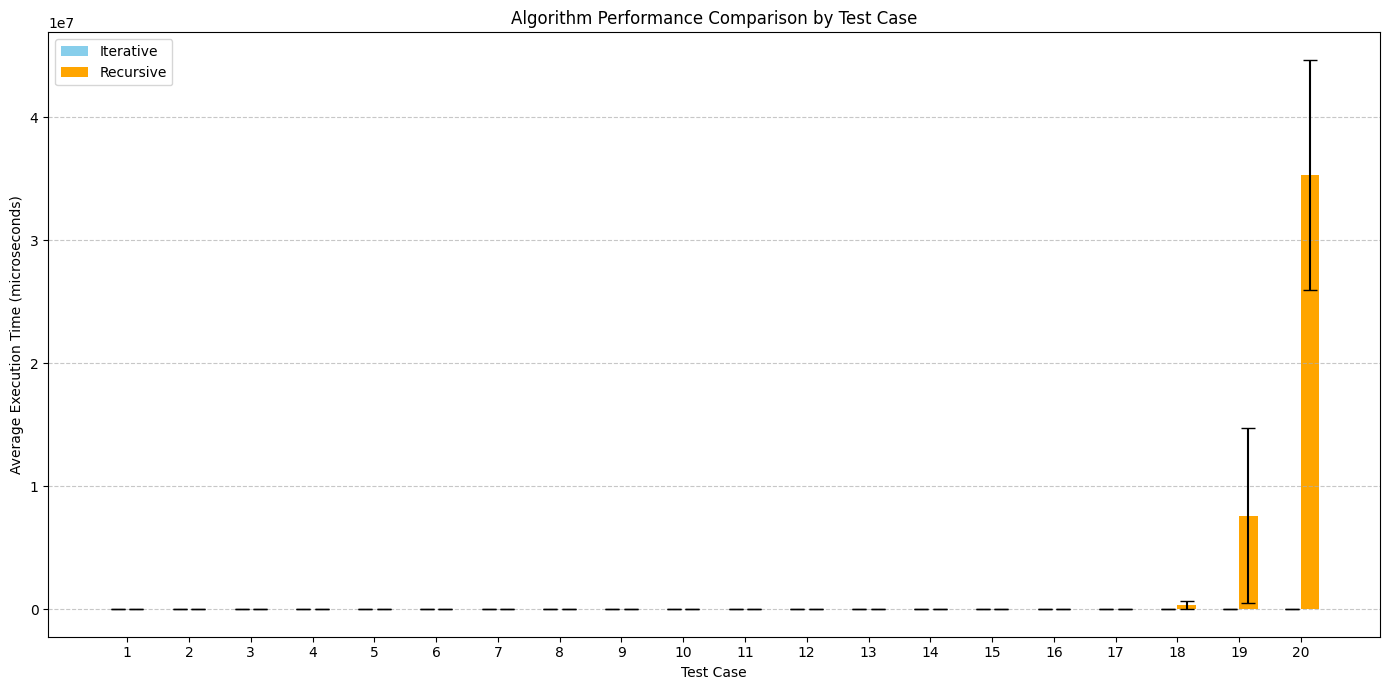

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean and standard deviation for error bars
iterative_stats = results_df.groupby('case')['iterative_time'].agg(['mean', 'std'])
recursive_stats = results_df.groupby('case')['recursive_time'].agg(['mean', 'std'])

plt.figure(figsize=(14, 7))

# Plot bars with error bars for standard deviation
plt.bar(iterative_stats.index - 0.15, iterative_stats['mean'], yerr=iterative_stats['std'],
        width=0.3, label='Iterative', capsize=5, color='skyblue')

plt.bar(recursive_stats.index + 0.15, recursive_stats['mean'], yerr=recursive_stats['std'],
        width=0.3, label='Recursive', capsize=5, color='orange')

# Add labels and titles
plt.xlabel('Test Case')
plt.ylabel('Average Execution Time (microseconds)')
plt.title('Algorithm Performance Comparison by Test Case')
plt.xticks(iterative_stats.index)  # Ensure all test cases appear
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()
